In [2]:
# import Serial libraries
import serial
import serial.tools.list_ports
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# list serial ports
ports = list(serial.tools.list_ports.comports())
for p in ports:
    print(p)

/dev/cu.wlan-debug - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbserial-56230387121 - USB Single Serial


In [4]:
# read a line of data from the serial port

# open the serial port
ser = serial.Serial('/dev/cu.usbserial-56230387121', 256000, timeout=1)
encoderData = ser.readline()
encoderData = ser.readline()
encoderData = encoderData.decode()
command = "<300, 400>"
ser.write(command.encode())
ser.close()

print(encoderData)

-0.141,-0.000,0.374,0.003,-48.233,-0.242,-10.000,-10.000,404,



In [5]:
decode_list = [
"linear_position", 
"linear_velocity", 
"shoulder_position", 
"shoulder_velocity", 
"elbow_position", 
"elbow_velocity",
"requested_vel_1",
"requested_vel_2",
"serial_tx_time",
# "time_since_last_command",
]

def safe_read(ser):
    timeout = 10
    while(timeout > 0):
        encoderData = ser.readline()
        try: # catch byte errors in encoderData.decode
            encoderData = encoderData.decode()
            encoderData = encoderData.split(",")
            if len(encoderData) - 1 == len(decode_list): # account for the \r\n 
                return encoderData[:-1]
            timeout -= 1
        except:
            timeout -= 1
    raise Exception("Timeout during Read")


In [6]:
# https://stackoverflow.com/questions/1133857/how-accurate-is-pythons-time-sleep
import time

def busy_sleep(duration, get_now=time.perf_counter):
    now = get_now()
    end = now + duration
    while now < end:
        now = get_now()

In [7]:
# latency tester function
# every 100 ms send an alternating command to the robot
# see how long it takes for the robot to mirror the command 

def test_serial_latencies():
    test_runs = 10
    test_runs_dup = test_runs
    sleep_duration = 0.001 # 1 ms
    command_period = 0.01 # 10 ms
    command_freq = command_period / sleep_duration
    command_1 = "<0.0, 0.0>"
    command_2 = "<1.0, 1.0>"

    # open the serial port
    ser = serial.Serial('/dev/cu.usbserial-56230387121', 256000, timeout=1)
    # flush the serial port
    ser.flush()

    _toggle = False
    # motor_encoder_velocity_buffer
    serial_vel_buffer = []
    loop_time_buffer = []
    requested_vel_buffer = []
    delay_buffer = []
    delay_count = 0
    counter = 0
    while(test_runs > 0):
        start = time.perf_counter()

        if counter % command_freq == 0:
            _toggle = not _toggle
            test_runs -= 1
            delay_buffer.append(delay_count)
            delay_count = 0

        if _toggle:
            ser.write(command_1.encode())
            requested_vel_buffer.append(0.0)
        else: 
            ser.write(command_2.encode())
            requested_vel_buffer.append(1.0)

        encoderData = safe_read(ser)
        serial_vel_buffer.append(encoderData[6])

        if (float(serial_vel_buffer[-1]) != float(requested_vel_buffer[-1])):
            delay_count += 1

        end = time.perf_counter()
        loop_time_buffer.append(end - start)

        counter += 1
        busy_sleep(sleep_duration)

    # close the serial port
    ser.write(command_1.encode())
    ser.close()

    # plot the loop time
    plt.title("Python loop time (s)")
    plt.plot(loop_time_buffer)
    plt.show()

    # plot the requested velocity vs the actual velocity
    plt.title("Requested Velocity vs Actual Velocity")
    x_axis = np.arange(0,counter) * sleep_duration
    print(len(x_axis), len(requested_vel_buffer), len(serial_vel_buffer))
    # put dots on each point 
    plt.plot(x_axis, requested_vel_buffer, label="Requested Velocity", marker='o')
    plt.plot(x_axis, serial_vel_buffer, label="Recievec Velocity", marker='o')
    plt.legend()
    plt.show()

    # plot cycles it takes for the robot to mirror the command
    plt.title("Cycles it takes for the robot to mirror the command")
    plt.plot(delay_buffer, marker='o')
    plt.show()

        

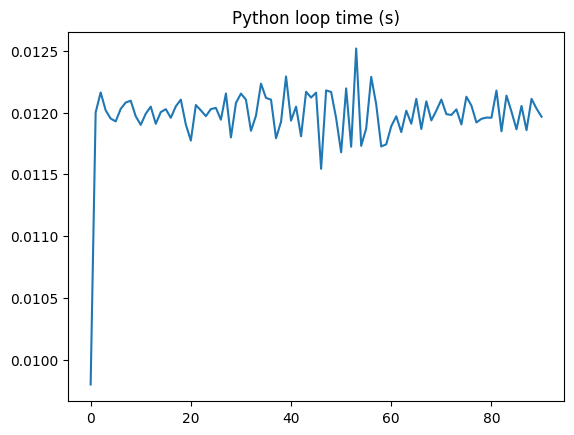

91 91 91


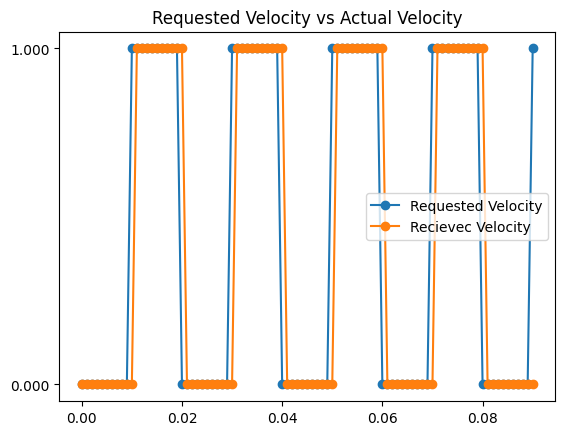

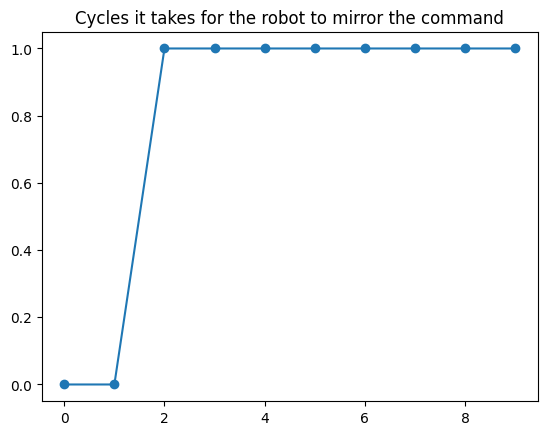

In [72]:
test_serial_latencies()

In [115]:
# Test goals: To see time taken from command generation to motion of the robot

# Graphs to make:
# Single graph with requested velocity command, recieved velocity command (serial), and then actual velocity (encoder)

# latency tester function
# every 100 ms send an alternating command to the robot
# see how long it takes for the robot to mirror the command 

def test_motor_latencies():
    test_runs = 2
    test_runs_dup = test_runs
    sleep_duration = 0.001 # 1 ms
    command_period = 0.05 # 1000 ms
    command_freq = command_period / sleep_duration
    command_1 = "<-100.0, -100.0>"
    command_2 = "<100.0, 100.0>"
    command_3 = "<0.0, 0.0>"

    # open the serial port
    ser = serial.Serial('/dev/cu.usbserial-56230387121', 256000, timeout=1)
    # flush the serial port
    ser.flush()

    _toggle = False
    serial_vel_buffer = []
    motor_encoder_velocity_buffer = []
    loop_time_buffer = []
    requested_vel_buffer = []
    delay_buffer = []
    delay_count = 0
    counter = 0
    while(test_runs > 0):
        start = time.perf_counter()

        if counter % command_freq == 0:
            _toggle = not _toggle
            test_runs -= 1
            delay_buffer.append(delay_count)
            delay_count = 0

        if _toggle:
            ser.write(command_1.encode())
            requested_vel_buffer.append(0.0)
        else: 
            ser.write(command_2.encode())
            requested_vel_buffer.append(1.0)

        encoderData = safe_read(ser)
        serial_vel_buffer.append(encoderData[6])
        motor_encoder_velocity_buffer.append(encoderData[5])

        if (float(serial_vel_buffer[-1]) != float(requested_vel_buffer[-1])):
            delay_count += 1

        end = time.perf_counter()
        loop_time_buffer.append(end - start)

        counter += 1
        busy_sleep(sleep_duration)

    # close the serial port
    ser.write(command_3.encode())
    ser.close()

    x_axis = np.arange(0,counter) * sleep_duration

    return counter, sleep_duration, x_axis, requested_vel_buffer, serial_vel_buffer, motor_encoder_velocity_buffer



In [128]:
counter, sleep_duration, x_axis, requested_vel_buffer, serial_vel_buffer, motor_encoder_velocity_buffer = test_motor_latencies()

51 51 51


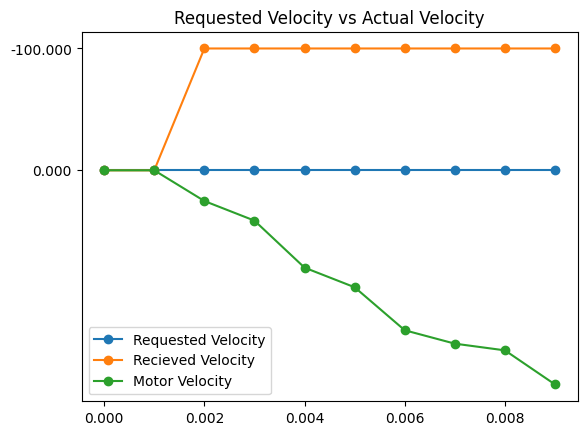

In [130]:
start = 0
end = 10
# plot the requested velocity vs the actual velocity
plt.title("Requested Velocity vs Actual Velocity")
print(len(x_axis), len(requested_vel_buffer), len(serial_vel_buffer))
# put dots on each point 
plt.plot(x_axis[start: end], requested_vel_buffer[start: end], label="Requested Velocity", marker='o')
plt.plot(x_axis[start: end], serial_vel_buffer[start: end], label="Recieved Velocity", marker='o')
plt.plot(x_axis[start: end], np.asarray(motor_encoder_velocity_buffer[start: end], float), label="Motor Velocity", marker='o')
# reduce number of ticks on the y axis
# plt.locator_params(axis='y', nbins=6)
plt.legend()
plt.show()

51 51 51


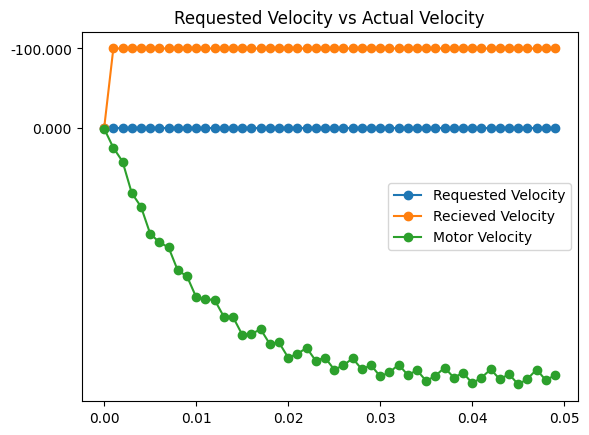

In [125]:
start = 0
end = -1
# plot the requested velocity vs the actual velocity
plt.title("Requested Velocity vs Actual Velocity")
print(len(x_axis), len(requested_vel_buffer), len(serial_vel_buffer))
# put dots on each point 
plt.plot(x_axis[start: end], requested_vel_buffer[start: end], label="Requested Velocity", marker='o')
plt.plot(x_axis[start: end], serial_vel_buffer[start: end], label="Recieved Velocity", marker='o')
plt.plot(x_axis[start: end], np.asarray(motor_encoder_velocity_buffer[start: end], float), label="Motor Velocity", marker='o')
# reduce number of ticks on the y axis
# plt.locator_params(axis='y', nbins=6)
plt.legend()
plt.show()
